## Figure S3a

In [6]:
import scanpy as sc
import stlearn as st
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
healthy = st.Read10X(path="../VLP4_A_Visium")
healthy.var_names_make_unique()
tmp = healthy[:,["Fcrls","Tmem119"]].to_df()
microglia_spots = tmp.sum(axis=1)[tmp.sum(axis=1)>1].index

sc.pp.filter_cells(healthy, min_genes=200)
sc.pp.filter_genes(healthy, min_cells=3)
healthy.var['mt'] = healthy.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(healthy, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# healthy = healthy[:,list(set(merged_upgenes+merged_downgenes) & set(healthy.var_names))]
healthy = healthy[healthy.obs.n_genes_by_counts < 7500, :]
healthy.raw = healthy

/sc/arion/work/shins21/test-env/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/sc/arion/work/shins21/test-env/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


/sc/arion/work/shins21/test-env/envs/stlearn/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


2024-12-04 16:34:25.774165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 16:34:25.956570: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 16:34:25.960722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/packages/minerva-rocky9/anaconda3/2024.06/lib:/hpc/packages/minerva-rocky9/gcc

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


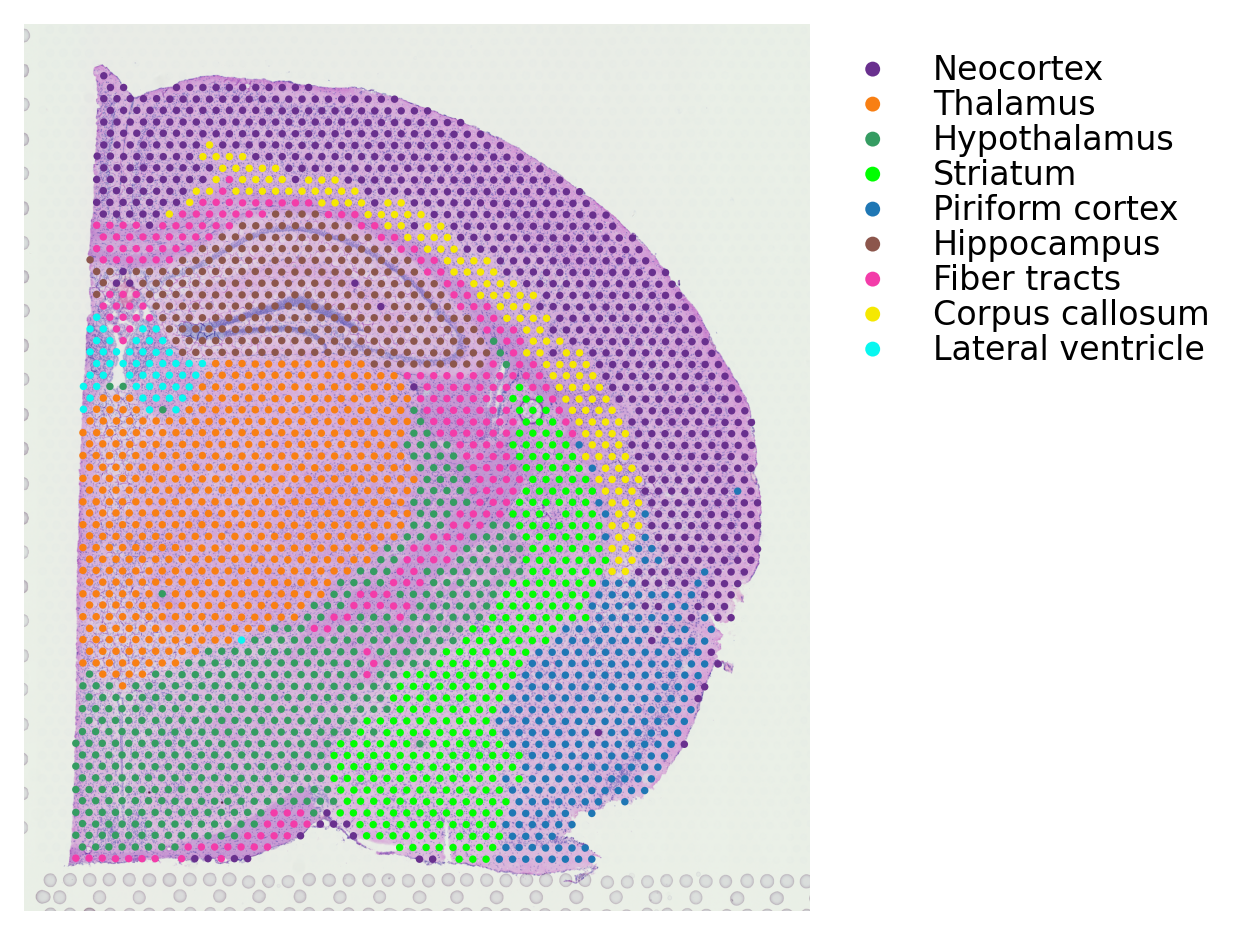

In [7]:
st.pp.normalize_total(healthy)
st.pp.log1p(healthy)
sc.pp.highly_variable_genes(healthy, min_mean=0.0025, max_mean=3, min_disp=0.5)
healthy = healthy[:, healthy.var.highly_variable]
st.pp.scale(healthy, max_value=10)
st.em.run_pca(healthy,n_comps=25,random_state=0)

st.settings.set_figure_params(dpi=120)
st.pp.neighbors(healthy,n_neighbors=25,use_rep='X_pca',random_state=0)
sc.tl.leiden(healthy,resolution=0.25,random_state=0)
st.settings.set_figure_params(dpi=120)

custom_labels = {
    '0': 'Neocortex',
    '1': 'Thalamus',
    '2': 'Hypothalamus',
    '3': 'Striatum',
    '4': 'Piriform cortex',
    '5': 'Hippocampus',
    '6': 'Fiber tracts',
    '7': 'Corpus callosum',
    '8': 'Lateral ventricle'
}
df = pd.DataFrame({'x': healthy.obs['array_col'], 'y': healthy.obs['array_row']})
df['leiden'] = healthy.obs['leiden'].values
df['leiden_label'] = df['leiden'].map(custom_labels)
healthy.obs['leiden'] = df['leiden_label'].astype('category')

healthy.uns['leiden_colors'] = [
    '#69308e',
    '#f87f13',
    '#359c62',
    '#00FF00',
    '#1f77b4',
    '#8c564c',
    '#f33ca9',
    '#f5e801',
    '#08f7f0'
]

st.pl.cluster_plot(healthy,use_label="leiden")

## Figure S3b

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.font_manager as fm

arial_font_path = '../test-env/envs/ONTraCv2/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf'
fm.fontManager.addfont(arial_font_path)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns

from ONTraC.analysis.data import AnaData

In [4]:
from optparse import Values

options = Values()
options.NN_dir = 'healthy_brain_reg1.5_NN'
options.GNN_dir = 'healthy_brain_reg1.5_GNN'
options.NT_dir = 'healthy_brain_reg1.5_NT'
options.log = '../log/healthy_brain_reg1.5'
options.reverse = True  # Set it to False if you don't want reverse NT score
options.embedding_adjust = False
options.output = None  # We save the output figure by our self here
ana_data = AnaData(options)

16:46:30 --- INFO: Cell level meta data loaded.


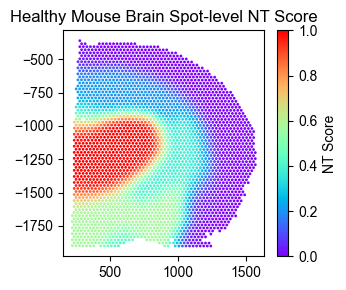

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

df = ana_data.NT_score

NT_score = df['Cell_NTScore']
trans = Affine2D().rotate_deg(270) + ax.transData
scatter = ax.scatter(df['x'], df['y'], c=NT_score, cmap='rainbow', vmin=0, vmax=1, s=1, transform=trans)
# ax.set_aspect('equal', 'box')  # uncomment this line if you want set the x and y axis with same scaling
# ax.set_xticks([])  # uncomment this line if you don't want to show x coordinates
# ax.set_yticks([]) # uncomment this line if you don't want to show y coordinates
plt.colorbar(scatter, label="NT Score")
ax.set_title("Healthy Mouse Brain Spot-level NT Score")

fig.tight_layout()